<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/XAI/Resnet_Final_1__with_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Import Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib  # For saving the trained model


In [2]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
#  DEFINE DATASET PATHS
DATA_DIR = '/content/drive/MyDrive/DSGP/dataset'
FEATURE_DIR = '/content/drive/MyDrive/extracted_feature'

#  GET IMAGE DIRECTORIES FROM DRIVE
def get_class_directories(base_directory):
    return {folder_name: os.path.join(base_directory, folder_name) for folder_name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, folder_name))}

image_directories = get_class_directories(DATA_DIR)
class_names = list(image_directories.keys())
print(f"Classes found: {class_names}")


Classes found: ['glaucoma', 'diabetic_retinopathy', 'normal', 'cataract']


In [4]:
#  SPLIT DATASET INTO TRAIN & TEST (80-20 Split)
train_dirs, test_dirs = {}, {}
for category, dir_path in image_directories.items():
    img_files = os.listdir(dir_path)
    train_files, test_files = train_test_split(img_files, test_size=0.2, random_state=42)
    train_dirs[category] = [os.path.join(dir_path, f) for f in train_files]
    test_dirs[category] = [os.path.join(dir_path, f) for f in test_files]


📂 First 5 Images from Each Category (Train & Test):

🔸 Category: glaucoma
🔸 Category: diabetic_retinopathy
🔸 Category: normal
🔸 Category: cataract


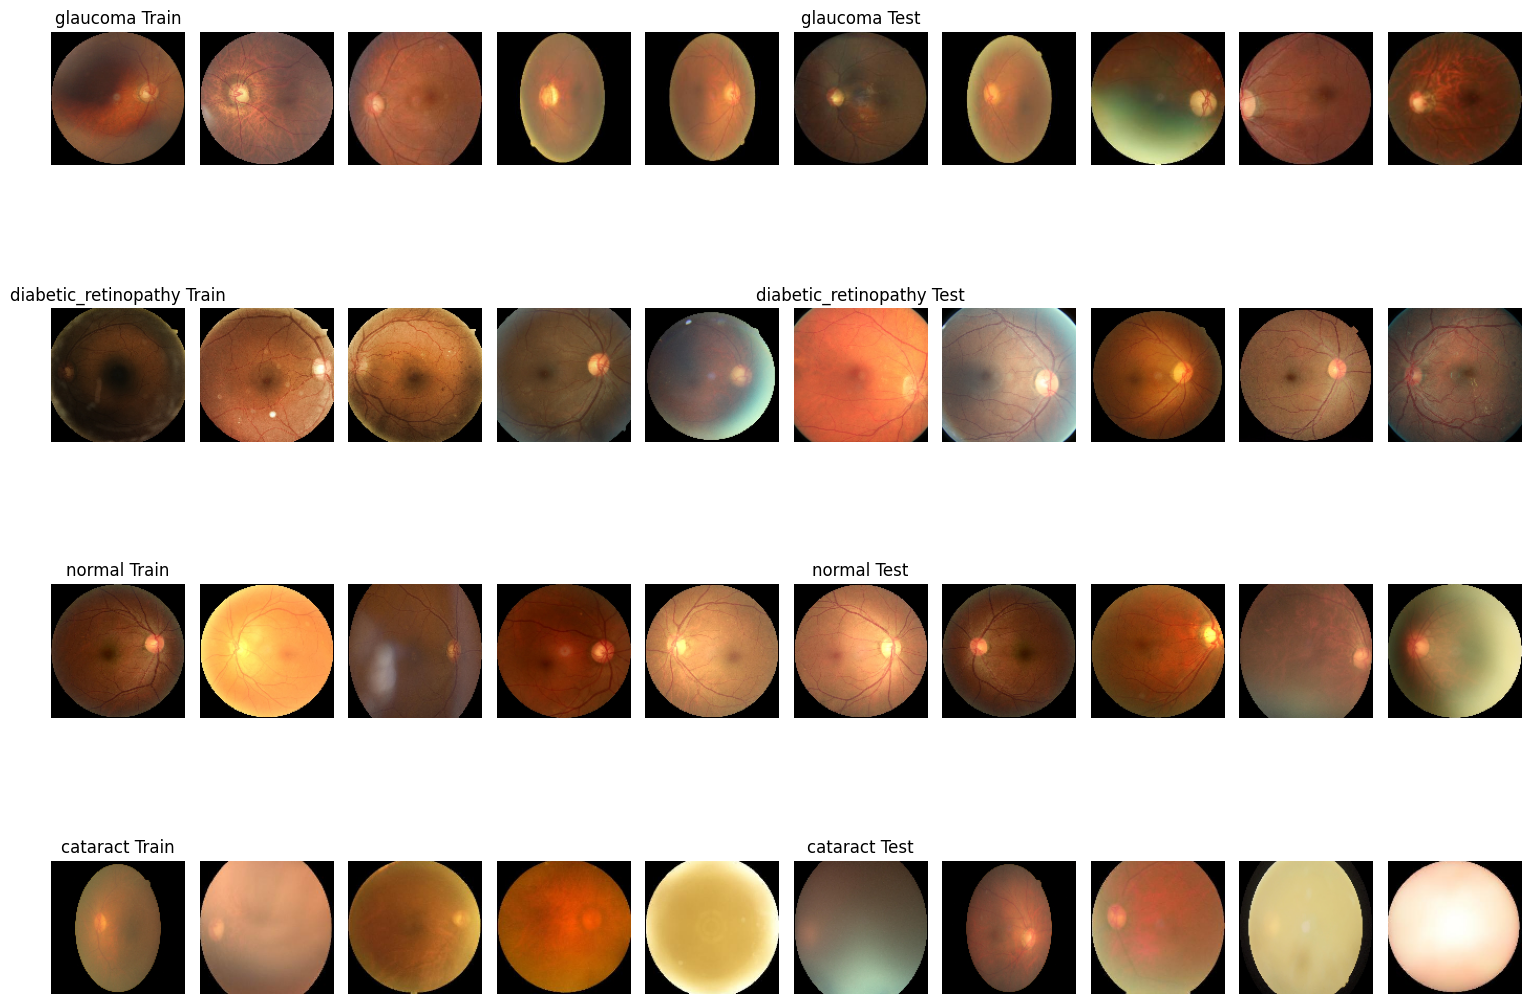

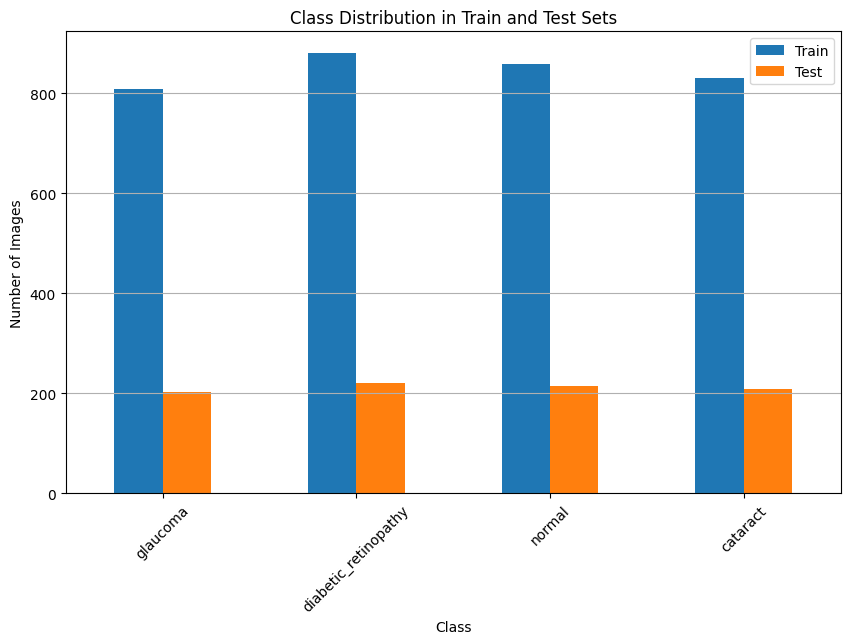

In [5]:
# 🖼️ Display first 5 images from each category
def display_first_five_images(train_dirs, test_dirs):
    print("📂 First 5 Images from Each Category (Train & Test):\n")

    num_categories = len(train_dirs)
    fig, axes = plt.subplots(num_categories, 10, figsize=(15, num_categories * 3))  # 10 columns: 5 for train, 5 for test

    for i, category in enumerate(train_dirs.keys()):
        print(f"🔸 Category: {category}")

        # Train Set
        for j, img_path in enumerate(train_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j].imshow(img)  # Columns 0-4 for train
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{category} Train', fontsize=12)

        # Test Set (continue from the next column)
        for j, img_path in enumerate(test_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j + 5].imshow(img)  # Columns 5-9 for test
            axes[i, j + 5].axis('off')
            if j == 0:
                axes[i, j + 5].set_title(f'{category} Test', fontsize=12)

    plt.tight_layout()
    plt.show()

# Call the function to display the first 5 images from both Train and Test sets
display_first_five_images(train_dirs, test_dirs)


#  Plot class distribution
def plot_class_distribution(train_dirs, test_dirs, class_names):
    train_counts = {category: len(files) for category, files in train_dirs.items()}
    test_counts = {category: len(files) for category, files in test_dirs.items()}

    df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts})
    df_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Class Distribution in Train and Test Sets')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_class_distribution(train_dirs, test_dirs, class_names)


In [6]:
#  LOAD PRE-TRAINED RESNET50 MODEL
def load_resnet50(input_shape=(224, 224, 3), trainability=False):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocessor = tf.keras.applications.resnet50.preprocess_input
    for layer in base_model.layers:
        layer.trainable = trainability
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
    return model, preprocessor

#  LOAD RESNET50 MODEL
model, preprocess_input = load_resnet50()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
#  FUNCTION TO EXTRACT FEATURES FROM IMAGES
def preprocess_and_extract_features(img_path, model, preprocess_input, img_size=(224, 224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features.flatten()

#  FUNCTION TO EXTRACT & SAVE FEATURES
def extract_and_save_features(image_files, model, preprocess_input, output_dir, category):
    features_list = [preprocess_and_extract_features(img, model, preprocess_input) for img in image_files]
    os.makedirs(output_dir, exist_ok=True)
    np.save(f'{output_dir}/{category}_features.npy', np.array(features_list))


#  EXTRACT & SAVE FEATURES FROM DRIVE DATASET
for split_name, dirs in zip(['train', 'test'], [train_dirs, test_dirs]):
    for category, image_files in dirs.items():
        output_dir = f'{FEATURE_DIR}/ResNet50/{split_name}'
        extract_and_save_features(image_files, model, preprocess_input, output_dir, category)


In [8]:
#  LOAD FEATURES FROM SAVED FILES
X_train, y_train, X_test, y_test = [], [], [], []
for category in class_names:
    train_features = np.load(f'{FEATURE_DIR}/ResNet50/train/{category}_features.npy')
    test_features = np.load(f'{FEATURE_DIR}/ResNet50/test/{category}_features.npy')
    X_train.append(train_features)
    y_train.append(np.full(train_features.shape[0], class_names.index(category)))
    X_test.append(test_features)
    y_test.append(np.full(test_features.shape[0], class_names.index(category)))

X_train, y_train = np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)
X_test, y_test = np.concatenate(X_test, axis=0), np.concatenate(y_test, axis=0)

In [9]:
# COMPUTE CLASS WEIGHTS
def get_class_weight_dict(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(zip(np.unique(y_train), class_weights))

#  TRAIN MULTIPLE SGD CLASSIFIERS WITH DIFFERENT LOSS FUNCTIONS
loss_functions = ["log_loss", "hinge", "modified_huber", "squared_hinge", "perceptron"]
class_weight_dict = get_class_weight_dict(y_train)

classifiers = []
for loss_function in loss_functions:
    clf = SGDClassifier(loss=loss_function, class_weight=class_weight_dict, max_iter=1000, learning_rate='adaptive', eta0=0.01, random_state=42)
    clf.fit(X_train, y_train)
    classifiers.append((loss_function, clf))

#  CREATE VOTING CLASSIFIER (ENSEMBLE OF MULTIPLE MODELS)
voting_clf = VotingClassifier(estimators=classifiers, voting="hard")
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


VotingClassifier(estimators=[('log_loss',
                              SGDClassifier(class_weight={0: 1.0448638613861385,
                                                          1: 0.959375,
                                                          2: 0.9828288707799767,
                                                          3: 1.0171686746987951},
                                            eta0=0.01, learning_rate='adaptive',
                                            loss='log_loss', random_state=42)),
                             ('hinge',
                              SGDClassifier(class_weight={0: 1.0448638613861385,
                                                          1: 0.959375,
                                                          2: 0.9828288707799767,
                                                          3: 1.0171686746987951},
                                            eta0=0.01, learning_rate='...
                              SGDClassifier(class_weight={0: 1.0448638613861385,
                                                          1: 0.959375,
                                                          2: 0.9828288707799767,
                                                          3: 1.0171686746987951},
                                            eta0=0.01, learning_rate='adaptive',
                                            loss='squared_hinge',
                                            random_state=42)),
                             ('perceptron',
                              SGDClassifier(class_weight={0: 1.0448638613861385,
                                                          1: 0.959375,
                                                          2: 0.9828288707799767,
                                                          3: 1.0171686746987951},
                                            eta0=0.01, learning_rate='adaptive',
                                            loss='perceptron',
                                            random_state=42))])

Test Accuracy for ('ResNet50',) with Voting Classifier: 0.9148
Classification Report:
                      precision    recall  f1-score   support

            glaucoma       0.89      0.82      0.86       202
diabetic_retinopathy       0.99      1.00      0.99       220
              normal       0.86      0.91      0.88       215
            cataract       0.92      0.92      0.92       208

            accuracy                           0.91       845
           macro avg       0.91      0.91      0.91       845
        weighted avg       0.91      0.91      0.91       845



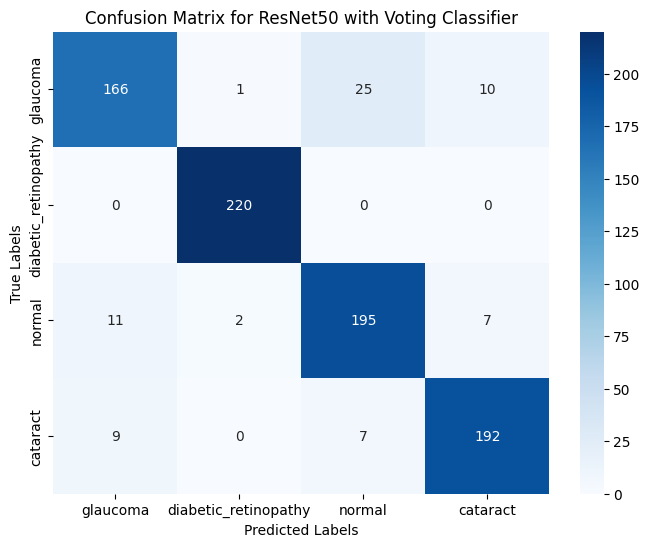

In [10]:
#  EVALUATE THE MODEL
y_pred = voting_clf.predict(X_test)

#  PRINT ACCURACY & CLASSIFICATION REPORT
print(f"Test Accuracy for ('ResNet50',) with Voting Classifier: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

#  CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for ResNet50 with Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [23]:
import h5py
import pickle

# Define the save path for the HDF5 file
model_save_path = '/content/drive/MyDrive/Sakuna_Eye_Disease_Detection_Model.h5'

# Save the model using joblib instead of HDF5
joblib.dump(voting_clf, model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at /content/drive/MyDrive/Sakuna_Eye_Disease_Detection_Model.h5


In [51]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from sklearn.svm import SGDClassifier
import joblib

# Load the image model (for feature extraction, not direct classification)
model_path = '/content/drive/MyDrive/Sakuna_Eye_Disease_Detection_Model.h5'
model = joblib.load(model_path)

# Preprocessing function
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # ResNet50 input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

# Path to new image in Drive
image_path = '/content/drive/MyDrive/DSGP/dataset/cataract/cataract_060.png'
preprocessed_image = preprocess_image(image_path)

# Extract features using ResNet50 (without the top classification layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = base_model.predict(preprocessed_image)  # Shape will be (1, 7, 7, 2048)

# Flatten the features to create a feature vector
flattened_features = features.flatten().reshape(1, -1)  # Shape: (1, 100352)

# Use the Scikit-learn model for prediction
prediction = model.predict(flattened_features)

# Get the predicted class label
predicted_class_label = class_names[prediction[0]]  # Assuming class_names are defined

print(f"Prediction: {predicted_class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Cataract


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


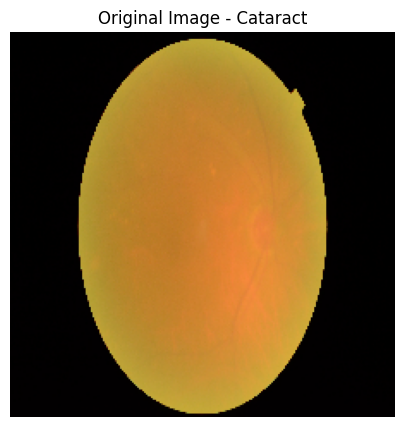

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

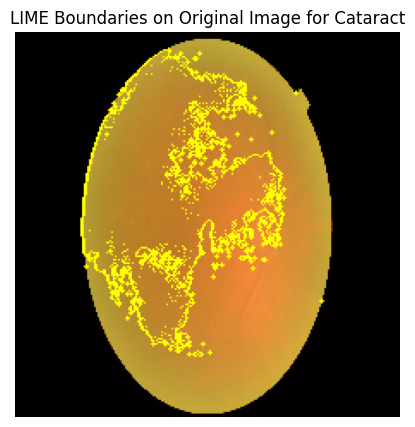

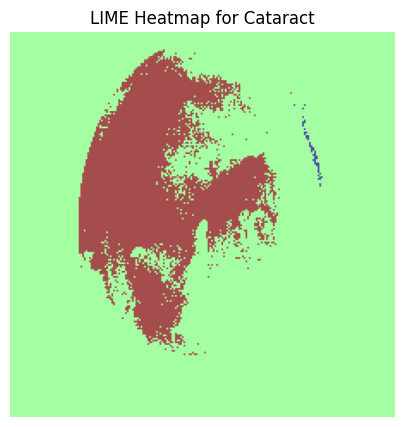

In [52]:
!pip install lime
import tensorflow as tf
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn.ensemble import VotingClassifier

# Load the trained Scikit-learn model (VotingClassifier)
model_path = '/content/drive/MyDrive/Sakuna_Eye_Disease_Detection_Model.h5'
model = joblib.load(model_path)

# Define class names
class_names = ["Normal", "Glaucoma", "Diabetic Retinopathy", "Cataract"]

# Path to image
image_path = '/content/drive/MyDrive/DSGP/dataset/cataract/cataract_060.png'

# Preprocessing function
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array, np.array(img)  # Return both preprocessed array and original image (NumPy)

# Process image
preprocessed_image, original_img = preprocess_image(image_path)

# Load base feature extractor (ResNet50 without top layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features
features = base_model.predict(preprocessed_image)
flattened_features = features.flatten().reshape(1, -1)

# Predict using Scikit-learn model
prediction = model.predict(flattened_features)
predicted_class_index = prediction[0]
predicted_class_label = class_names[predicted_class_index]

# Handle models without predict_proba()
def predict_proba(features):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(features)
    else:
        preds = model.predict(features)
        proba = np.zeros((len(preds), len(class_names)))
        for i, p in enumerate(preds):
            proba[i, p] = 1.0
        return proba

# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(original_img.astype('uint8'))
plt.axis('off')
plt.title(f"Original Image - {predicted_class_label}")
plt.show()

# Instantiate LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define function for LIME explanation
def classifier_fn(images):
    features = base_model.predict(images)
    features = features.reshape(features.shape[0], -1)
    return predict_proba(features)

# Generate LIME explanation
explanation = explainer.explain_instance(
    original_img.astype('double'),
    classifier_fn=classifier_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get LIME boundaries on original image
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display original image with LIME boundaries
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(original_img.astype('uint8'), mask))
plt.axis('off')
plt.title(f'LIME Boundaries on Original Image for {predicted_class_label}')
plt.show()

# Display LIME heatmap
heatmap = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)[1]

plt.figure(figsize=(5, 5))
plt.imshow(heatmap, cmap="jet", alpha=0.7)
plt.axis('off')
plt.title(f'LIME Heatmap for {predicted_class_label}')
plt.show()
